Have you spent some time on Twitter lately? So strange that politics is the main topic in so many tweets these days... Can we do something about it? YES!

I follow 124 tweeps at the time of this writing. You can see a list of them [here](https://twitter.com/curiousily/following). 200 of the most recent tweets for each account have been collected using the Twitter API. Here is what each row of our dataset contains:

* text - text of the tweet
* favorite_count
* retweet_count
* created_at - when the tweet was published
* lang - language in which the tweet is written
* user - screen name (username) of the user
* user_tweet_count
* user_following_count
* user_followers_count
* user_location

Only the text will be useful for us here. Feel free to use the other fields as well!

# Loading libraries

Make sure you have installed and loaded the following libraries:

In [34]:
library(tm)
library(dplyr)
library(doMC)
library(RColorBrewer)
library(wordcloud)
library(ggplot2)
library(SnowballC)
library(topicmodels)
library(LDAvis)

Let's setup R and make our results reproducible.

In [2]:
seed <- 42
set.seed(seed)
theme_set(theme_minimal())
registerDoMC(cores = 4)
options(warn=-1)

# Load the data

In [3]:
df <- read.csv("data/tweets.csv", header = T, stringsAsFactors = F)

Since our dataset is pretty well sorted (by username) we would love to randomize it a bit and tell R that `created_at` is an actual date field:

In [4]:
df <- df[sample(nrow(df)),]
rownames(df) <- 1:nrow(df)

In [5]:
df$created_at <- as.Date(df$created_at)

In [6]:
dim(df)

[1] 19948    10

We have a total of 19948 tweets - no missing data

# Splitting the tweets

Let's remove all non-ASCII characters and reserve only 10 tweets for testing:

In [8]:
tweets <- iconv(df$text, to = "ASCII", sub = " ")
train_tweets <- tweets[1:(nrow(df) - 10)]
test_tweets <- tweets[(nrow(df) - 9):nrow(df)]

# Preprocessing

Now, let's prepare our text. Remove punctuations, numbers, URLs, stop words and apply stemming to the result.

In [9]:
create_corpus <- function(data) {
    data <- tolower(data)
    data <- gsub("rt", " ", data)  # Remove retweets
    data <- gsub("@\\w+", " ", data)  # Remove usernames
    data <- gsub("http.+ |http.+$", " ", data)  # Remove links
    data <- gsub("[[:punct:]]", " ", data)  # Remove punctuation
    data <- gsub("[ |\t]{2,}", " ", data)  # Remove tabs
    data <- gsub("amp", " ", data)  # Remove "&amp"
    data <- gsub("^ ", "", data)  # Leading blanks
    data <- gsub(" $", "", data)  # Lagging blanks
    data <- gsub(" +", " ", data) # General white spaces
    data <- unique(data)  
    VCorpus(VectorSource(data))
}

In [10]:
train_corpus <- create_corpus(train_tweets)

Our newly created corpus will be fed to a [Document-Term matrix](https://en.wikipedia.org/wiki/Document-term_matrix).

In [11]:
dtm_train <- DocumentTermMatrix(train_corpus, control = list(
    stemming = TRUE, removeNumbers = TRUE,
    removePunctuation = TRUE, stopwords = c(stopwords("en"), stopwords("SMART")), 
    wordLengths = c(3, 15)))
dtm_train <- dtm_train[, !grepl("http", dtm_train$dimnames$Terms)]

Remove zero row entries

In [12]:
row_totals <- apply(dtm_train , 1, sum)
dtm_train <- dtm_train[row_totals > 0, ] 

# Exploration

Let's see which words are most used using our newly created corpus (set of documents).

In [13]:
tdm_train <- TermDocumentMatrix(train_corpus, control = list(
    stemming = TRUE, removeNumbers = TRUE, 
    removePunctuation = TRUE, stopwords = c(stopwords("en"), stopwords("SMART")), 
    wordLengths = c(3, 15)))

In [14]:
term_freq <- rowSums(as.matrix(tdm_train))
term_freq <- subset(term_freq, term_freq >= 300)
freq_df <- data.frame(term = names(term_freq), freq = term_freq)

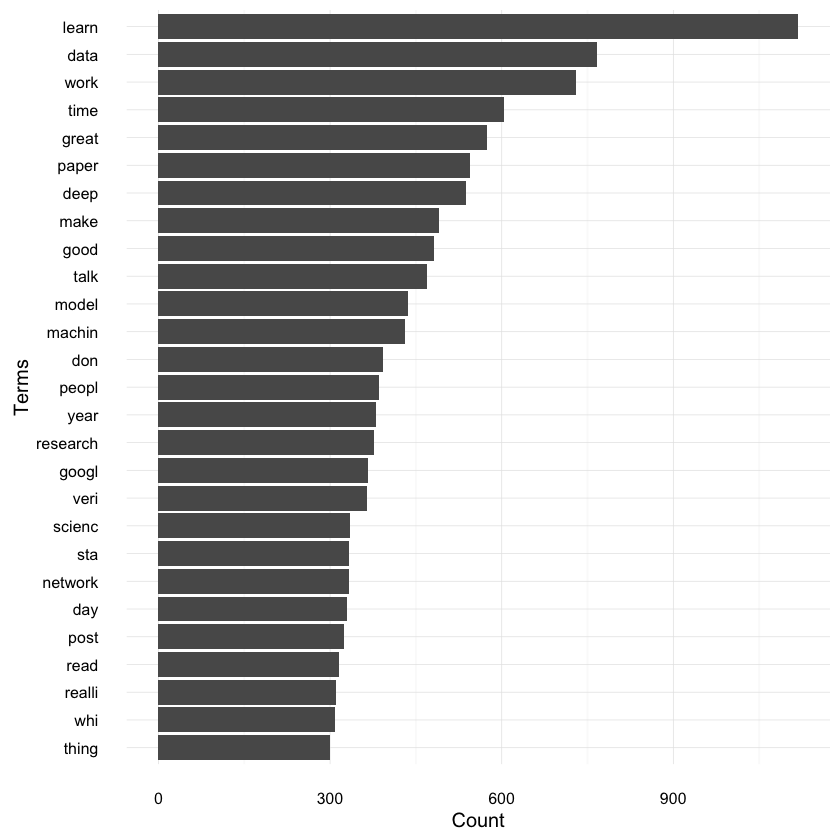

In [15]:
ggplot(freq_df, aes(x=reorder(term, freq), y=freq)) + 
    geom_bar(stat="identity") +
    xlab("Terms") + ylab("Count") + coord_flip()

Want to make a guess what kind of tweeps I follow most? What about major topics?

Why not make a wordcloud using the same data?

In [16]:
m <- as.matrix(tdm_train)
word.freq <- sort(rowSums(m), decreasing = T)

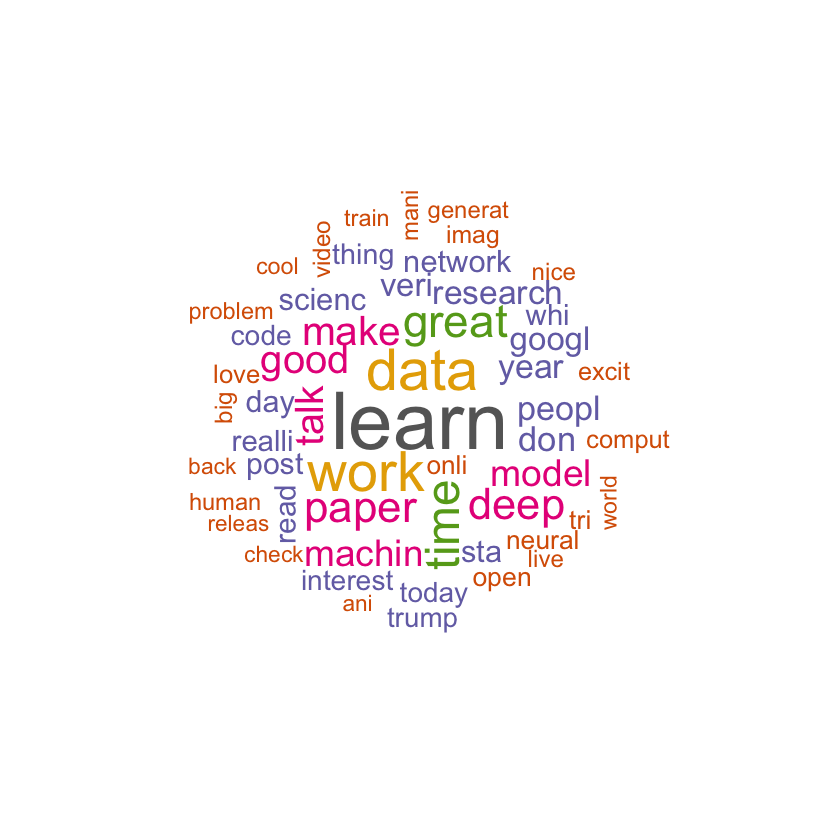

In [17]:
wordcloud(words = names(word.freq), freq = word.freq, min.freq = 200,
random.order = F, colors=brewer.pal(8, "Dark2"))

We can even find associations in our corpus. Let's see what is most associated to the word `data`?

In [29]:
findAssocs(tdm_train, "data", 0.07)

$data
   scienc scientist       big    elixir    ingenu   janitor  servanda      mung 
     0.22      0.18      0.14      0.10      0.10      0.10      0.10      0.09 
   effici  literaci    driven 
     0.08      0.08      0.07

So it's data science, data scientist, and big data? Looks reasonable enough!

# Training our model

We will use the package `topicmodels` to train Latent Dirichlet Allocation (LDA) model using our tweet corpus.  One good explanation of what exactly LDA is can be found [on Quora](https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation). Concretely (get it?), we will use Gibbs sampling to find 10 (randomly picked number) topics.

In [19]:
burnin <- 4000
iter <- 2000
thin <- 500
lda <- LDA(dtm_train, k = 10, method = "Gibbs", 
           control = list(burnin = burnin, thin = thin, iter = iter, seed = seed))

Now that we trained our model, which words best describe each topic?

In [20]:
terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
time,learn,read,data,work,make,paper,peopl,great,googl
year,deep,nice,research,veri,good,open,don,talk,human
day,machin,lot,scienc,interest,thing,code,trump,today,game
world,model,show,big,cool,mani,python,whi,live,team
app,network,write,comput,problem,idea,releas,ani,excit,alphago
everi,post,love,futur,high,sta,result,realli,video,play
anoth,neural,book,program,thought,chang,sourc,question,week,deepmind
life,imag,mayb,machinelearn,impo,probabl,review,onli,workshop,experi
email,generat,pretti,intellig,ant,yeah,tool,doe,give,person
man,train,feel,predict,find,doesn,final,twitter,present,brain


# Predicting topics of new data

Using the test data might not seem trivial at first, but creating corpus from the test tweets is a good first step.

In [21]:
test_corpus <- create_corpus(test_tweets)

Let's create Document-Term matrix using the test corpus and use our training matrix terms as a dictionary.

In [22]:
dtm_test <- DocumentTermMatrix(test_corpus, control = list(
    stemming = TRUE, removeNumbers = TRUE, 
    removePunctuation = TRUE, stopwords = c(stopwords("en"), stopwords("SMART")), 
    dictionary=Terms(dtm_train), wordLengths = c(3, 15)))

dtm_test <- dtm_test[, !grepl("http", dtm_test$dimnames$Terms)]
row_totals <- apply(dtm_test , 1, sum)
dtm_test   <- dtm_test[row_totals> 0, ] 

Finally, assign topic probabilities to each tweet in our test dataset.

In [23]:
lda_posterior <- posterior(lda, dtm_test)

In [24]:
lda_posterior$topics

,1,2,3,4,5,6,7,8,9,10
1,0.12500000,0.08928571,0.10714286,0.08928571,0.08928571,0.12500000,0.08928571,0.08928571,0.08928571,0.10714286
2,0.12500000,0.08928571,0.08928571,0.08928571,0.10714286,0.10714286,0.08928571,0.08928571,0.10714286,0.10714286
3,0.09433962,0.11320755,0.09433962,0.09433962,0.09433962,0.09433962,0.09433962,0.09433962,0.11320755,0.11320755
4,0.08928571,0.08928571,0.10714286,0.10714286,0.08928571,0.12500000,0.10714286,0.08928571,0.10714286,0.08928571
5,0.11111111,0.11111111,0.07936508,0.11111111,0.11111111,0.07936508,0.09523810,0.11111111,0.09523810,0.09523810
6,0.11666667,0.10000000,0.08333333,0.11666667,0.10000000,0.08333333,0.08333333,0.11666667,0.11666667,0.08333333
7,0.09090909,0.12727273,0.09090909,0.09090909,0.09090909,0.09090909,0.09090909,0.09090909,0.09090909,0.14545455
8,0.08474576,0.10169492,0.08474576,0.13559322,0.08474576,0.11864407,0.08474576,0.11864407,0.08474576,0.10169492
9,0.08928571,0.08928571,0.08928571,0.08928571,0.08928571,0.10714286,0.08928571,0.16071429,0.10714286,0.08928571
10,0.08474576,0.08474576,0.10169492,0.11864407,0.08474576,0.08474576,0.08474576,0.15254237,0.11864407,0.08474576


Now, let's pick the most probable topic for each tweet:

In [25]:
test_topics <- apply(lda_posterior$topics, 1, which.max)

In [26]:
test_topics

1  2  3  4  5  6  7  8  9 10 
 1  1  2  6  1  1 10  4  8  8

Ready to have a look at the actual tweets?

In [27]:
for(i in seq_along(test_tweets)) {
    cat(paste(paste(i, test_tweets[i], sep = ": "), "\n\n"))
}

1: Here I am at my new job at @King_Games and guess who shows up for a meeting? Jack Parmer ceo at @plotlygraphs !! :D https://t.co/EtuVWZcFzO 

2: RT @ocelma: We're interested in both, but I wanted to stress today the implications of #wtf in #recsys https://t.co/sRZ2Re8W4u 

3: RT @JordiTorresBCN:   Google ofrece m  s #MachineLearning a los desarrolladores!  https://t.co/yaLxQuL0BF #CloudComputing #TensorFlow https:/    

4: Today's freshwater invert puzzling many... caddisflies! @freshwaterbio #namethatinvert https://t.co/EEZeTwnH0M 

5: @dribnet impossible for Google to host the images themselves, because of legal issues. Large companies are a prime target for    lawsuits. 

6: RT @polylogblog: Overheard at dinner re. decreasing importance of combinatorial algorithms: "these days, in order to sort, you first comput    

7: RT @sedielem: Recurrent Spatial Transformer Networks by S  ren S  nderby et al. http://t.co/YJXyitvjko code: https://t.co/vYZcjbkmOH http://t    

8: RT @skilpat:

Again, the top 5 terms for each topic:

In [31]:
apply(terms(lda, 5), MARGIN = 2, paste, collapse = ", ")

Topic 1                               Topic 2 
        "time, year, day, world, app" "learn, deep, machin, model, network" 
                              Topic 3                               Topic 4 
       "read, nice, lot, show, write" "data, research, scienc, big, comput" 
                              Topic 5                               Topic 6 
"work, veri, interest, cool, problem"       "make, good, thing, mani, idea" 
                              Topic 7                               Topic 8 
  "paper, open, code, python, releas"         "peopl, don, trump, whi, ani" 
                              Topic 9                              Topic 10 
    "great, talk, today, live, excit"   "googl, human, game, team, alphago"

What do you think about the results? Remember that every tweet is limited to 140 characters, thus our documents are rather small (even tiny considering preprocessing).

Let's visualize our LDA model using the sweet `LDAvis` package.

In [32]:
topicmodels2LDAvis <- function(x, ...){
    post <- topicmodels::posterior(x)
    if (ncol(post[["topics"]]) < 3) stop("The model must contain > 2 topics")
    mat <- x@wordassignments
    LDAvis::createJSON(
        phi = post[["terms"]], 
        theta = post[["topics"]],
        vocab = colnames(post[["terms"]]),
        doc.length = slam::row_sums(mat, na.rm = TRUE),
        term.frequency = slam::col_sums(mat, na.rm = TRUE)
    )
}

In [33]:
json <- lda %>% topicmodels2LDAvis()

LDAvis::serVis(json, out.dir = 'twitter_lda_vis', open.browser = FALSE)

Loading required namespace: servr


It looks like 3 `(2, 4, 8)` of the topics are pretty well separated from any other topic. We have 5 topics that are pretty close to each other on the bottom right. Might it be a good idea to try a different number of topics then?

At the end of the day, our model looks pretty useful. Let's not forget that the data is pretty fresh and real (yes - I do not follow many tweeps, mostly those that are interested in math, machine learning and biotech/bioinformatics).

One could easily imagine using the trained model for making personalized recommendations of tweets based on preselected topics. Why not recommending new tweeps, too?

The LDA is very general and can be applied to any set of documents. Why not try it on papers, news or Facebook posts?

# References

* [Basic Text Mining in R](https://rstudio-pubs-static.s3.amazonaws.com/31867_8236987cf0a8444e962ccd2aec46d9c3.html)
* [A Gentle Introduction to Topic Modeling in R](https://eight2late.wordpress.com/2015/09/29/a-gentle-introduction-to-topic-modeling-using-r/)
* [Introduction to LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)
* [Topic Modeling of Tweets in R](https://www.academia.edu/19255535/Topic_Modeling_of_Tweets_in_R_A_Tutorial_and_Methodology)
* [Twitter Data Analysys with R](http://wombat2016.org/slides/yanchang.pdf)
* [Topic Models Learning and R Resources](https://github.com/trinker/topicmodels_learning)
* [A topic model for movie reviews](https://cpsievert.github.io/LDAvis/reviews/reviews.html)
* [Topic Modeling using R](https://gist.github.com/bryangoodrich/7b5ef683ce8db592669e)